In [1]:
import time

import torch
import torch.nn as nn
import copy
import torchvision.models as models
from torchvision import datasets, models, transforms
import torch.nn.functional as F
from torch.autograd import Variable

from sklearn.metrics import confusion_matrix

import numpy as np

import cv2

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import seaborn as sn
import pandas as pd


In [2]:
# use shuffle net to train the model, set pretrained=True for transfer learning
shuffle_net = models.shufflenet_v2_x1_0(progress=True)

In [3]:
!unzip fer2013.zip

流式输出内容被截断，只能显示最后 5000 行内容。
 extracting: train/surprised/16451.jpg  
 extracting: train/surprised/16456.jpg  
 extracting: train/surprised/16461.jpg  
 extracting: train/surprised/16466.jpg  
 extracting: train/surprised/16497.jpg  
 extracting: train/surprised/16507.jpg  
 extracting: train/surprised/16512.jpg  
 extracting: train/surprised/16514.jpg  
 extracting: train/surprised/16526.jpg  
 extracting: train/surprised/16530.jpg  
 extracting: train/surprised/16538.jpg  
 extracting: train/surprised/16543.jpg  
 extracting: train/surprised/16555.jpg  
 extracting: train/surprised/16594.jpg  
 extracting: train/surprised/16598.jpg  
 extracting: train/surprised/16618.jpg  
 extracting: train/surprised/16620.jpg  
 extracting: train/surprised/16627.jpg  
 extracting: train/surprised/16637.jpg  
 extracting: train/surprised/16641.jpg  
 extracting: train/surprised/16644.jpg  
 extracting: train/surprised/16646.jpg  
 extracting: train/surprised/16655.jpg  
 extracting: train/surprised/1

In [4]:
shuffle_net

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [5]:
BATCH_SIZE = 32

In [6]:
# some data augmentation.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(44),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize(44),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize(44),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor()
    ])
}
transform = transforms.Compose([
                #  transforms.Resize(224),
                 transforms.RandomHorizontalFlip(),
                 transforms.RandomRotation(10),
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0,0,0], std=[1,1,1]),
                 ])
device = torch.device("cuda:0")

In [7]:
def load_data(folder):
    # load data from FER2013 dataset
    train_data = datasets.ImageFolder(folder+"/train", data_transforms["train"])
    valid_data = datasets.ImageFolder(folder+"/val", data_transforms["val"])
    test_data = datasets.ImageFolder(folder+"/test", data_transforms["test"])

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
    
    image_datasets = {"train": train_data, "val": valid_data, "test": test_data}
    dataloaders = {"train": train_loader, "val": valid_loader, "test": test_loader}
    dataset_sizes = {"train": len(train_data), "val": len(valid_data), "test": len(test_data)}
    return image_datasets, dataloaders, dataset_sizes, train_data.classes

In [8]:
image_datasets, dataloaders, dataset_sizes, classes = load_data('.')

In [9]:
classes

['anger', 'disgust', 'fear', 'happy', 'normal', 'sad', 'surprised']

In [10]:
# for transfer learning
# for param in pretrained_shuffle_net.parameters():
#     param.requires_grad = False

# update the output classes
num_ftrs = shuffle_net.fc.in_features
shuffle_net.fc = torch.nn.Linear(num_ftrs, len(classes), bias=True)

shuffle_net = shuffle_net.to(device)

# define loss function
criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# tune hyperparameters here
# optimizer_ft = torch.optim.SGD(pretrained_shuffle_net.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft = torch.optim.Adam(shuffle_net.parameters(), lr=0.001, weight_decay=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.01)

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, epoches, losses, acc):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            losses[phase].append(epoch_loss)
            acc[phase].append(epoch_acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoches, losses, acc

In [15]:
# general train
best_model, epoches, loss, acc = train_model(shuffle_net, criterion, optimizer_ft, exp_lr_scheduler, 100,[],{"train": [], "val": []},{"train": [], "val": []})

Epoch 0/99
----------
train Loss: 1.4829 Acc: 0.4239
val Loss: 1.6842 Acc: 0.3221

Epoch 1/99
----------
train Loss: 1.4708 Acc: 0.4309
val Loss: 1.5431 Acc: 0.3990

Epoch 2/99
----------


KeyboardInterrupt: ignored

In [ ]:
# fine tune
best_model, epoches, loss, acc = train_model(best_model, criterion, optimizer_ft, exp_lr_scheduler, 10, epoches, loss, acc)

Epoch 0/9
----------
train Loss: 0.8648 Acc: 0.6868
val Loss: 1.1282 Acc: 0.5843

Epoch 1/9
----------
train Loss: 0.8613 Acc: 0.6865
val Loss: 1.1406 Acc: 0.5865

Epoch 2/9
----------
train Loss: 0.8618 Acc: 0.6877
val Loss: 1.1310 Acc: 0.5907

Epoch 3/9
----------
train Loss: 0.8550 Acc: 0.6945
val Loss: 1.1355 Acc: 0.5918

Epoch 4/9
----------
train Loss: 0.8525 Acc: 0.6890
val Loss: 1.1351 Acc: 0.5837

Epoch 5/9
----------
train Loss: 0.8564 Acc: 0.6892
val Loss: 1.1486 Acc: 0.5773

Epoch 6/9
----------
train Loss: 0.8545 Acc: 0.6930
val Loss: 1.1241 Acc: 0.5913

Epoch 7/9
----------
train Loss: 0.8553 Acc: 0.6914
val Loss: 1.1341 Acc: 0.5868

Epoch 8/9
----------
train Loss: 0.8485 Acc: 0.6941
val Loss: 1.1392 Acc: 0.5826

Epoch 9/9
----------
train Loss: 0.8476 Acc: 0.6934
val Loss: 1.1377 Acc: 0.5829

Training complete in 5m 59s
Best val Acc: 0.591808


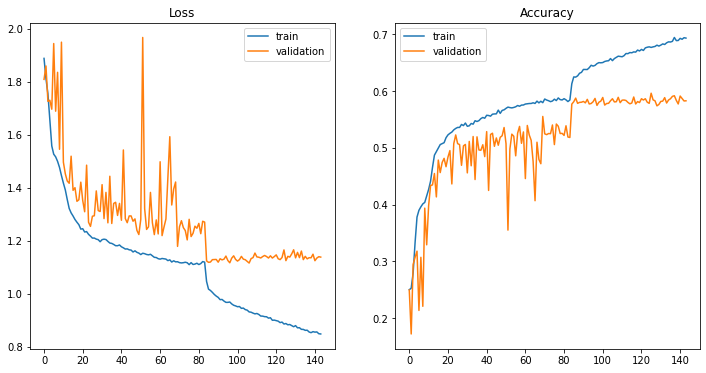

In [ ]:
epoches = [i for i in range(144)]
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Loss")
l1,=plt.plot(epoches, loss["train"])
l2,=plt.plot(epoches, loss["val"])
plt.legend([l1,l2], ["train", "validation"])

plt.subplot(1,2,2)
plt.title("Accuracy")
l1,=plt.plot(epoches, acc["train"])
l2,=plt.plot(epoches, acc["val"])
plt.legend([l1,l2], ["train", "validation"])

plt.show()

In [ ]:
def test_model(model, criterion, optimizer, scheduler):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    print('-' * 10)

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    # for inputs, labels in dataloaders["test"]:
    #   print(torch.max(inputs), labels)
    #   break
    true_label = []
    pred_label = []
    # Iterate over data.
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        true_label.append(labels.tolist()[0])
        pred_label.append(preds.tolist()[0])

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes["test"]
    epoch_acc = running_corrects.double() / dataset_sizes["test"]

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        "test", epoch_loss, epoch_acc))

    print()

    time_elapsed = time.time() - since
    print('Testing complete in {}m {}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return confusion_matrix(true_label, pred_label)

In [ ]:
conf_matrix = test_model(best_model, criterion, optimizer_ft, exp_lr_scheduler)

----------
test Loss: 1.0580 Acc: 0.6141

Testing complete in 0.0m 15.50033950805664s


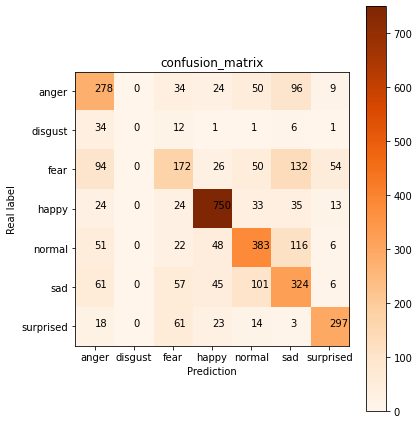

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Oranges) 
plt.title('confusion_matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
 
thresh = conf_matrix.max() / 2.
# draw confusion matrix
iters = np.reshape([[[i,j] for j in range(len(classes))] for i in range(len(classes))],(conf_matrix.size,2))
for i, j in iters:
    plt.text(j, i, format(conf_matrix[i, j]))   #显示对应的数字
 
plt.ylabel('Real label')
plt.xlabel('Prediction')
plt.tight_layout()
plt.show()